# Autoencoders

```
- Autoencoder is a system that teaches itself how to encode information.
- It's used for:
  - Dimensionality reduction.
  - Feature extraction.
  - Anomaly detection.

- It consists of:
  - Encoder.
  - Bottleneck/latent/code.
  - Decoder.

- The encoder compresses the input data into a lower dimensional representation.
- The decoder reconstructs the original data from the compressed represenation.
```

<br>

## Architecture

[![image.png](https://i.postimg.cc/hjjMjbrf/image.png)](https://postimg.cc/FfM0CSw4)


In [1]:
# Built-in library
import logging
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 2_000

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import (
    set_up_logger,
    create_iris_data,
    create_qwerties_data,
    smooth,
)
from src.data_manager import (
    load_data,
    create_data_loader,
    split_into_train_n_validation,
)
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
fp = "../../data/mnist_digit/mnist_train.csv"
mnist_data = load_data(filename=fp)

mnist_data.head()

Shape of data: (60000, 785)



,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,2x13,2x14,2x15,2x16,2x17,2x18,2x19,2x20,2x21,2x22,2x23,2x24,2x25,2x26,2x27,2x28,3x1,3x2,3x3,3x4,3x5,3x6,3x7,3x8,3x9,3x10,3x11,3x12,3x13,3x14,3x15,3x16,3x17,3x18,3x19,3x20,3x21,3x22,3x23,3x24,3x25,3x26,3x27,3x28,4x1,4x2,4x3,4x4,4x5,4x6,4x7,4x8,4x9,4x10,4x11,4x12,4x13,4x14,4x15,4x16,4x17,4x18,4x19,4x20,4x21,4x22,4x23,4x24,4x25,4x26,4x27,4x28,5x1,5x2,5x3,5x4,5x5,5x6,5x7,5x8,5x9,5x10,5x11,5x12,5x13,5x14,5x15,5x16,5x17,5x18,5x19,5x20,5x21,5x22,5x23,5x24,5x25,5x26,5x27,5x28,6x1,6x2,6x3,6x4,6x5,6x6,6x7,6x8,6x9,6x10,6x11,6x12,6x13,6x14,6x15,6x16,6x17,6x18,6x19,6x20,6x21,6x22,6x23,6x24,6x25,6x26,6x27,6x28,7x1,7x2,7x3,7x4,7x5,7x6,7x7,7x8,7x9,7x10,7x11,7x12,7x13,7x14,7x15,7x16,7x17,7x18,7x19,7x20,7x21,7x22,7x23,7x24,7x25,7x26,7x27,7x28,8x1,8x2,8x3,8x4,8x5,8x6,8x7,8x8,8x9,8x10,8x11,8x12,8x13,8x14,8x15,8x16,8x17,8x18,8x19,8x20,8x21,8x22,8x23,8x24,8x25,8x26,8x27,8x28,9x1,9x2,9x3,9x4,9x5,9x6,9x7,9x8,9x9,9x10,9x11,9x12,9x13,9x14,9x15,9x16,9x17,9x18,9x19,9x20,9x21,9x22,9x23,9x24,9x25,9x26,9x27,9x28,10x1,10x2,10x3,10x4,10x5,10x6,10x7,10x8,10x9,10x10,10x11,10x12,10x13,10x14,10x15,10x16,10x17,10x18,10x19,10x20,10x21,10x22,10x23,10x24,10x25,10x26,10x27,10x28,11x1,11x2,11x3,11x4,11x5,11x6,11x7,11x8,11x9,11x10,11x11,11x12,11x13,11x14,11x15,11x16,11x17,11x18,11x19,11x20,11x21,11x22,11x23,11x24,11x25,11x26,11x27,11x28,12x1,12x2,12x3,12x4,12x5,12x6,12x7,12x8,12x9,12x10,12x11,12x12,12x13,12x14,12x15,12x16,12x17,12x18,12x19,12x20,12x21,12x22,12x23,12x24,12x25,12x26,12x27,12x28,13x1,13x2,13x3,13x4,13x5,13x6,13x7,13x8,13x9,13x10,13x11,13x12,13x13,13x14,13x15,13x16,13x17,13x18,13x19,13x20,13x21,13x22,13x23,13x24,13x25,13x26,13x27,13x28,14x1,14x2,14x3,14x4,14x5,14x6,14x7,14x8,14x9,14x10,14x11,14x12,14x13,14x14,14x15,14x16,14x17,14x18,14x19,14x20,14x21,14x22,14x23,14x24,14x25,14x26,14x27,14x28,15x1,15x2,15x3,15x4,15x5,15x6,15x7,15x8,15x9,15x10,15x11,15x12,15x13,15x14,15x15,15x16,15x17,15x18,15x19,15x20,15x21,15x22,15x23,15x24,15x25,15x26,15x27,15x28,16x1,16x2,16x3,16x4,16x5,16x6,16x7,16x8,16x9,16x10,16x11,16x12,16x13,16x14,16x15,16x16,16x17,16x18,16x19,16x20,16x21,16x22,16x23,16x24,16x25,16x26,16x27,16x28,17x1,17x2,17x3,17x4,17x5,17x6,17x7,17x8,17x9,17x10,17x11,17x12,17x13,17x14,17x15,17x16,17x17,17x18,17x19,17x20,17x21,17x22,17x23,17x24,17x25,17x26,17x27,17x28,18x1,18x2,18x3,18x4,18x5,18x6,18x7,18x8,18x9,18x10,18x11,18x12,18x13,18x14,18x15,18x16,18x17,18x18,18x19,18x20,18x21,18x22,18x23,18x24,18x25,18x26,18x27,18x28,19x1,19x2,19x3,19x4,19x5,19x6,19x7,19x8,19x9,19x10,19x11,19x12,19x13,19x14,19x15,19x16,19x17,19x18,19x19,19x20,19x21,19x22,19x23,19x24,19x25,19x26,19x27,19x28,20x1,20x2,20x3,20x4,20x5,20x6,20x7,20x8,20x9,20x10,20x11,20x12,20x13,20x14,20x15,20x16,20x17,20x18,20x19,20x20,20x21,20x22,20x23,20x24,20x25,20x26,20x27,20x28,21x1,21x2,21x3,21x4,21x5,21x6,21x7,21x8,21x9,21x10,21x11,21x12,21x13,21x14,21x15,21x16,21x17,21x18,21x19,21x20,21x21,21x22,21x23,21x24,21x25,21x26,21x27,21x28,22x1,22x2,22x3,22x4,22x5,22x6,22x7,22x8,22x9,22x10,22x11,22x12,22x13,22x14,22x15,22x16,22x17,22x18,22x19,22x20,22x21,22x22,22x23,22x24,22x25,22x26,22x27,22x28,23x1,23x2,23x3,23x4,23x5,23x6,23x7,23x8,23x9,23x10,23x11,23x12,23x13,23x14,23x15,23x16,23x17,23x18,23x19,23x20,23x21,23x22,23x23,23x24,23x25,23x26,23x27,23x28,24x1,24x2,24x3,24x4,24x5,24x6,24x7,24x8,24x9,24x10,24x11,24x12,24x13,24x14,24x15,24x16,24x17,24x18,24x19,24x20,24x21,24x22,24x23,24x24,24x25,24x26,24x27,24x28,25x1,25x2,25x3,25x4,25x5,25x6,25x7,25x8,25x9,25x10,25x11,25x12,25x13,25x14,25x15,25x16,25x17,25x18,25x19,25x20,25x21,25x22,25x23,25x24,25x25,25x26,25x27,25x28,26x1,26x2,26x3,26x4,26x5,26x6,26x7,26x8,26x9,26x10,26x11,26x12,26x13,26x14,26x15,26x16,26x17,26x18,26x19,26x20,26x21,26x22,26x23,26x24,26x25,26x26,26x27,26x28,27x1,27x2,27x3,27x4,27x5,27x6,27x7,27x8,27x9,27x10,27x11,27x12,27x13,27x14,27x15,27x16,27x17,27x18,27x19,27x20,

In [3]:
# It does not require labelled data (target variable)
X = mnist_data.iloc[:, 1:]

# Normalize data
X_norm = X / np.max(X)  # Since np.min(X) = 0
X_norm = torch.Tensor(X_norm.to_numpy())

X_norm.shape

torch.Size([60000, 784])

#### Build Model

In [4]:
class AutoEncoder(nn.Module):
    """This is used to build an FFN Autoencoder model."""

    def __init__(self, n_encoder: int, latent: int) -> None:
        super().__init__()
        # Input
        self.input = nn.Linear(784, n_encoder)

        # Encoder
        self.encoder_ = nn.Linear(n_encoder, latent)

        # Latent
        self.latent_ = nn.Linear(latent, n_encoder)

        # Decoder
        self.decoder_ = nn.Linear(n_encoder, 784)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used for forward propagation."""
        X = F.relu(self.input(X))
        X = F.relu(self.encoder_(X))
        X = F.relu(self.latent_(X))

        # Normalize the output: It returns values between 0 and 1
        y = torch.sigmoid(self.decoder_(X))
        return y

In [5]:
# Test the model's architecture
sample_data = X_norm[:10, :]

auto_enc = AutoEncoder(n_encoder=250, latent=50)

auto_enc.forward(sample_data)

tensor([[0.4987, 0.5048, 0.4860,  ..., 0.4888, 0.4834, 0.4927],
        [0.4998, 0.5063, 0.4854,  ..., 0.4851, 0.4791, 0.4864],
        [0.4975, 0.5053, 0.4857,  ..., 0.4876, 0.4843, 0.4903],
        ...,
        [0.4961, 0.5026, 0.4825,  ..., 0.4862, 0.4838, 0.4895],
        [0.4981, 0.5058, 0.4883,  ..., 0.4900, 0.4840, 0.4915],
        [0.4949, 0.5046, 0.4855,  ..., 0.4887, 0.4855, 0.4915]],
       grad_fn=<SigmoidBackward0>)

In [6]:
def train_autoencoder_model(
    *, model: AutoEncoder, X: torch.Tensor, epochs: int, learning_rate: float
) -> tuple[torch.Tensor, AutoEncoder]:
    """This is used to train the Autoencoder model."""
    SIZE, criterion = 50, nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    losses = torch.zeros(size=(epochs,))

    for epoch_idx in np.arange(epochs):
        # Reset gradients
        optimizer.zero_grad()

        # Select a random set of images
        random_idx = np.random.choice(a=X.shape[0], size=SIZE)
        data_ = X[random_idx, :]

        # Forward prop and loss
        y_pred = model(data_)
        # Compare the decoded data with the original data
        loss = criterion(y_pred, data_)

        # Backprop
        loss.backward()
        optimizer.step()

        # Record the losses
        losses[epoch_idx] = loss.item()

    return losses, model

In [7]:
auto_enc = AutoEncoder(n_encoder=250, latent=50)
EPOCHS, LEARNING_RATE = 10_000, 0.0001

losses, trained_auto_enc = train_autoencoder_model(
    model=auto_enc, X=X_norm, epochs=EPOCHS, learning_rate=LEARNING_RATE
)

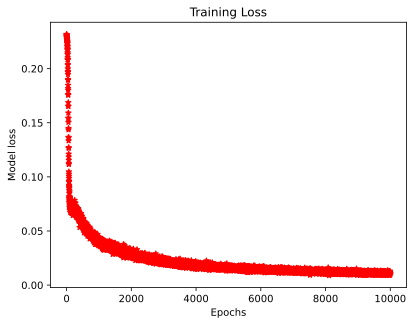

In [8]:
# Visualize the losses
plt.plot(losses, "r*")
plt.xlabel("Epochs")
plt.ylabel("Model loss")
plt.title("Training Loss")
plt.show()

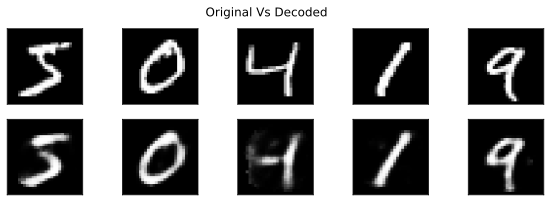

In [9]:
# Repeat the visualization when testing the model
sample_data = X_norm[:5, :]
y_pred = trained_auto_enc(sample_data)


# let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for idx in range(5):
    axs[0, idx].imshow(sample_data[idx, :].view(28, 28).detach(), cmap="gray")
    axs[1, idx].imshow(y_pred[idx, :].view(28, 28).detach(), cmap="gray")
    axs[0, idx].set_xticks([]), axs[0, idx].set_yticks([])
    axs[1, idx].set_xticks([]), axs[1, idx].set_yticks([])

plt.suptitle("Original Vs Decoded")
plt.show()

#### Comment


```text
- The original images were encoded and decoded.
- This decoded images are compressed versions of the original images.
- Autoecncoder was used in this example to reduce the dimensionality of the data.
```

### De-noise

```text
i.e remove noise from the data.
```

In [10]:
sample_data = X_norm[:20, :]

# Add noise to the data
data_noise = sample_data + (torch.rand_like(input=sample_data) / 4)

torch.min(data_noise), torch.max(data_noise)

(tensor(1.0148e-05), tensor(1.2485))

In [11]:
# Clip the tensor at 1. i.e. the max value should be 1.
data_noise[data_noise > 1] = 1

# Verify
torch.min(data_noise), torch.max(data_noise)

(tensor(1.0148e-05), tensor(1.))

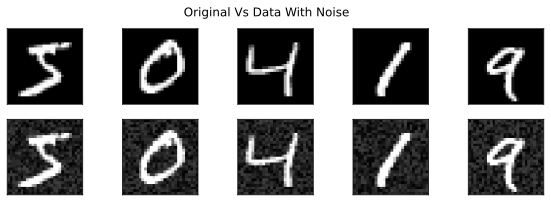

In [12]:
# Show the noisy images
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for idx in range(5):
    axs[0, idx].imshow(sample_data[idx, :].view(28, 28).detach(), cmap="gray")
    axs[1, idx].imshow(data_noise[idx, :].view(28, 28).detach(), cmap="gray")
    axs[0, idx].set_xticks([]), axs[0, idx].set_yticks([])
    axs[1, idx].set_xticks([]), axs[1, idx].set_yticks([])

plt.suptitle("Original Vs Data With Noise")
plt.show()

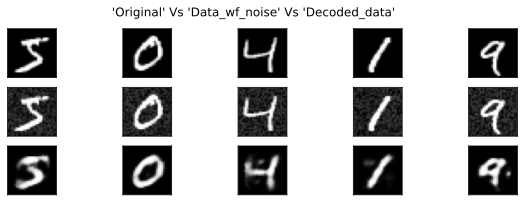

In [13]:
# De-noise the data; remove the noise
y_pred = trained_auto_enc(data_noise)


# Visualize
fig, axs = plt.subplots(3, 5, figsize=(10, 3))

for idx in range(5):
    axs[0, idx].imshow(sample_data[idx, :].view(28, 28).detach(), cmap="gray")
    axs[1, idx].imshow(data_noise[idx, :].view(28, 28).detach(), cmap="gray")
    axs[2, idx].imshow(y_pred[idx, :].view(28, 28).detach(), cmap="gray")
    axs[0, idx].set_xticks([]), axs[0, idx].set_yticks([])
    axs[1, idx].set_xticks([]), axs[1, idx].set_yticks([])
    axs[2, idx].set_xticks([]), axs[2, idx].set_yticks([])

plt.suptitle("'Original' Vs 'Data_wf_noise' Vs 'Decoded_data'")
plt.show()

In [14]:
def train_autoencoder_model(
    *, model: AutoEncoder, X: torch.Tensor, epochs: int, learning_rate: float
) -> tuple[torch.Tensor, AutoEncoder]:
    """This is used to train the Autoencoder model. This implementation is
    similar to using PyTorch's dataloader."""

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    losses = np.zeros(shape=(epochs,))

    # batch size and number of batches
    batch_size = 32
    num_batches = int(X.shape[0] / batch_size)

    for epoch_idx in np.arange(epochs):
        random_idx = np.random.permutation(X.shape[0]).astype(int)
        batch_losses = []

        for batch_idx in np.arange(num_batches):
            # Reset gradients
            optimizer.zero_grad()

            # ========== Implement mini-batches ==========
            # Select the images
            samples = np.arange((batch_idx - 1) * batch_size, batch_idx * batch_size)
            data_ = X[random_idx[samples], :]

            # Forward prop and loss
            y_pred = model(data_)
            # Compare the decoded data with the original data
            loss = criterion(y_pred, data_)

            # Backprop
            loss.backward()
            optimizer.step()

            # Batch losses
            batch_losses.append(loss.item())

        # Average of the last 3 training losses
        losses[epoch_idx] = np.mean(batch_losses[-3:])

    return losses, model

#### Parametric Experiment

```text
- Parametrically manipulate:
  - encoding units (10-500 in 12 steps)
  - latent units (5-100 in 8 steps)
  - Calculate the average of the last three losses.
```

In [15]:
import sys


EPOCHS, LEARNING_RATE = 3, 0.001

# The number of units
NUM_ENC_UNITS = np.linspace(10, 500, 8).astype(int)
NUM_LATENT_UNITS = np.linspace(5, 100, 5).astype(int)


# Initialize results matrix
exp_results = np.zeros((len(NUM_ENC_UNITS), len(NUM_LATENT_UNITS)))


# Start the experiment!
for enc_idx, n_enc in enumerate(NUM_ENC_UNITS):

    for latent_idx, n_latent in enumerate(NUM_LATENT_UNITS):
        # Train the model
        auto_enc = AutoEncoder(n_encoder=n_enc, latent=n_latent)
        losses, _ = train_autoencoder_model(
            model=auto_enc, X=X_norm, epochs=EPOCHS, learning_rate=LEARNING_RATE
        )
        exp_results[enc_idx, latent_idx] = np.mean(losses[-1])

        # Send update message
        current_iter = enc_idx * len(NUM_LATENT_UNITS) + latent_idx + 1
        total_iters = len(NUM_LATENT_UNITS) * len(NUM_ENC_UNITS)
        msg = f"Finished experiment {current_iter}/{total_iters}"
        sys.stdout.write("\r" + msg)

Finished experiment 40/40

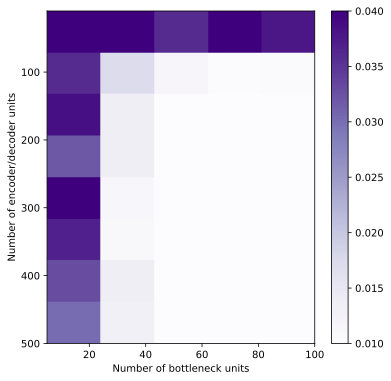

In [16]:
# show the results matrix
fig = plt.figure(figsize=(6, 6))

plt.imshow(
    exp_results,
    aspect="auto",  # data and aspect ratio
    vmin=0.01,
    vmax=0.04,
    cmap="Purples",  # color range and palette
    extent=[
        NUM_LATENT_UNITS[0],
        NUM_LATENT_UNITS[-1],
        NUM_ENC_UNITS[-1],
        NUM_ENC_UNITS[0],
    ],
)  # xy axis ticks


plt.xlabel("Number of bottleneck units")
plt.ylabel("Number of encoder/decoder units")
plt.colorbar()

plt.show()

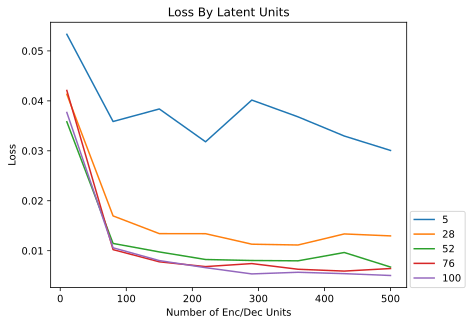

In [17]:
# perhaps a line plot will better reveal the sudden transition

plt.plot(NUM_ENC_UNITS, exp_results)
plt.legend(NUM_LATENT_UNITS, loc=(1.01, 0))
plt.xlabel("Number of Enc/Dec Units")
plt.title("Loss By Latent Units")
plt.ylabel("Loss")
plt.show()

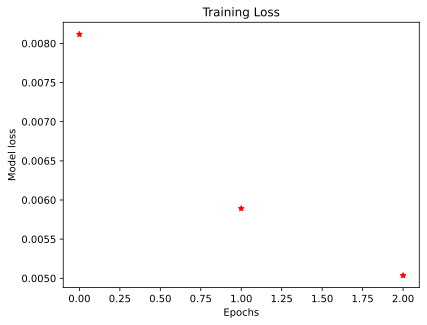

In [18]:
# Visualize the losses
plt.plot(losses, "r*")
plt.xlabel("Epochs")
plt.ylabel("Model loss")
plt.title("Training Loss")
plt.show()

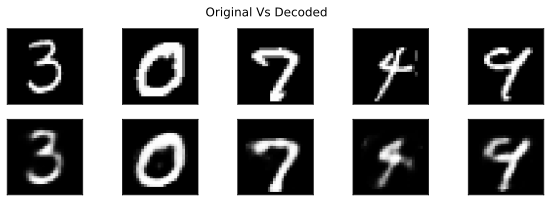

In [19]:
# Repeat the visualization when testing the model
sample_data = X_norm[50:55, :]
y_pred = trained_auto_enc(sample_data)


# let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for idx in range(5):
    axs[0, idx].imshow(sample_data[idx, :].view(28, 28).detach(), cmap="gray")
    axs[1, idx].imshow(y_pred[idx, :].view(28, 28).detach(), cmap="gray")
    axs[0, idx].set_xticks([]), axs[0, idx].set_yticks([])
    axs[1, idx].set_xticks([]), axs[1, idx].set_yticks([])

plt.suptitle("Original Vs Decoded")
plt.show()